# Single-Atom Local Gaussian Fit
This minimal notebook builds a single-atom projected potential, places one Gaussian beam at the centre, and compares the Gaussian phase with the local potential curvature. We also show a 1D phase cross-section.

In [1]:
# Imports and config
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.1'
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from ase import Atoms
import abtem
from abtem.core.energy import energy2wavelength, energy2sigma

from temgym_core.utils import fibonacci_spiral
from temgym_core.components import Detector
from temgym_core.gaussian import GaussianRayBeta
from temgym_core.gaussian_taylor import Potential, run_to_end, evaluate_gaussian_packets_jax_scan
from skimage.restoration import unwrap_phase

jax.config.update('jax_enable_x64', True)
%matplotlib widget

In [2]:
# Build a single-atom projected potential and a Gaussian at the centre
def make_single_atom(symbol='Si', box_A=(20.0, 20.0, 20.0)):
    Lx, Ly, Lz = map(float, box_A)
    return Atoms(
        symbols=symbol,
        positions=[[Lx / 2, Ly / 2, Lz / 2]],
        cell=[Lx, Ly, Lz],
        pbc=False
    )

def projected_potential_2d(
    src,
    sampling_A=0.02,
    parametrization='lobato',
    projection='infinite',
    periodic=False,
    box_A=None,
    slice_thickness=1.0
):
    # Use abTEM to compute projected potential and return V2d with sampling/origin matching temgym Potential
    if isinstance(src, Atoms):
        pot = abtem.Potential(
            src,
            sampling=sampling_A,
            parametrization=parametrization,
            projection=projection,
            periodic=periodic,
            slice_thickness=slice_thickness,
            box=None if box_A is None else tuple(map(float, box_A))
        )
        proj = pot.project().compute()
        V2d = np.asarray(proj.array)
        sy, sx = proj.sampling
    elif hasattr(src, 'project') and hasattr(src, 'compute'):
        proj = src.project().compute()
        V2d = np.asarray(proj.array)
        sy, sx = proj.sampling
    else:
        raise TypeError('Unsupported src for projected_potential_2d')
    ny, nx = V2d.shape
    Lx, Ly = nx * sx, ny * sy
    x0, y0 = -Lx / 2.0, -Ly / 2.0
    return V2d, float(sx), float(sy), float(x0), float(y0)

In [14]:
# Parameters
accel_V = 200_000
wavelength = energy2wavelength(accel_V)
sigma = energy2sigma(accel_V)
k = 2 * jnp.pi / wavelength
# Single atom
Lx, Ly, Lz = 2.0, 2.0, 2.0
atoms = make_single_atom('Si', box_A=(Lx, Ly, Lz))
V2d, sx, sy, x0, y0 = projected_potential_2d(atoms, sampling_A=0.025, parametrization='lobato', projection='infinite', periodic=False, box_A=(Lx, Ly, Lz))

potential = Potential(z=0.0, V=jnp.asarray(V2d, dtype=jnp.float64), sx=sx, sy=sy, x0=x0, y0=y0, order=3)

# Build a small detector/grid for field evaluation
W = Lx  # window size in Å
Nx, Ny = V2d.shape[1], V2d.shape[0]
dx = W / Nx
dy = W / Ny
grid = Detector(z=0.0, pixel_size=(dy, dx), shape=(Ny, Nx))

extent = (x0, x0 + Nx * dx, y0, y0 + Ny * dy)

w0 = 0.01
num_rays = 1
rx, ry = fibonacci_spiral(num_rays, radius=0.5)
rx = rx + 0.1
lam = jnp.ones(num_rays) * wavelength
k0 = 2 * jnp.pi / lam
C0 = jnp.ones(num_rays) * (1.0 + 0.0j)
eta = jnp.zeros((num_rays, 2), dtype=jnp.complex128)
scale = -1j * (2.0 / (k0 * w0**2))
Qinv0 = scale[..., None, None] * jnp.eye(2, dtype=jnp.complex128)
ray_in = GaussianRayBeta(x=rx, 
                         y=ry, 
                         dx=jnp.zeros_like(rx), 
                         dy=jnp.zeros_like(ry), 
                         z=jnp.zeros_like(rx), 
                         pathlength=jnp.zeros_like(rx), 
                         Q_inv=Qinv0, 
                         eta=eta, 
                         C=C0, 
                         voltage=jnp.full_like(rx, accel_V))
ray_in = ray_in.to_vector()

components = [potential]


[                                        ] | 0% Completed | 328.00 us

[########################################] | 100% Completed | 209.64 ms


/home/dl277493/Microscope-Calibration/TemGymCore/src/temgym_core/utils.py:310: RuntimeWarning: invalid value encountered in sqrt
  radius * np.sqrt((ii + 0.5) / (nb_samples - 0.5 * (np_boundary + 1)))


In [15]:
input_probe = evaluate_gaussian_packets_jax_scan(ray_in, grid, batch_size=32)

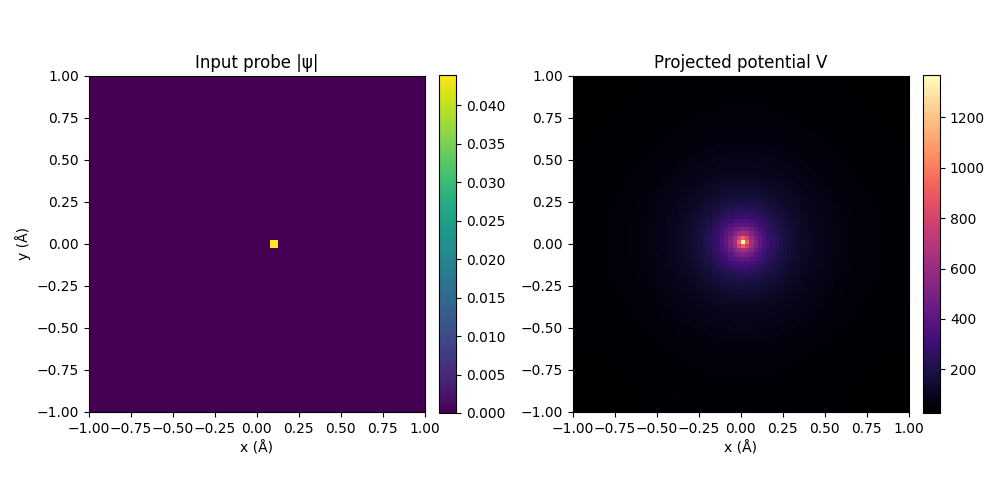

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

im0 = axes[0].imshow(np.abs(np.asarray(input_probe)), extent=extent, origin='lower', cmap='viridis')
axes[0].set_title('Input probe |ψ|')
axes[0].set_xlabel('x (Å)')
axes[0].set_ylabel('y (Å)')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(np.asarray(potential.V), extent=extent, origin='lower', cmap='magma')
axes[1].set_title('Projected potential V')
axes[1].set_xlabel('x (Å)')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [17]:
ray_out = run_to_end(ray_in, components)
gaussian_field = evaluate_gaussian_packets_jax_scan(ray_out, grid, batch_size=32)

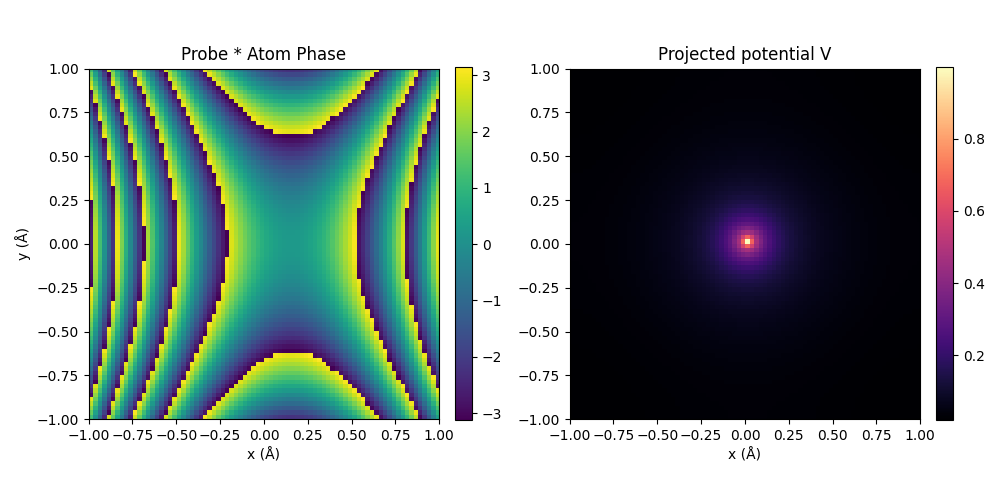

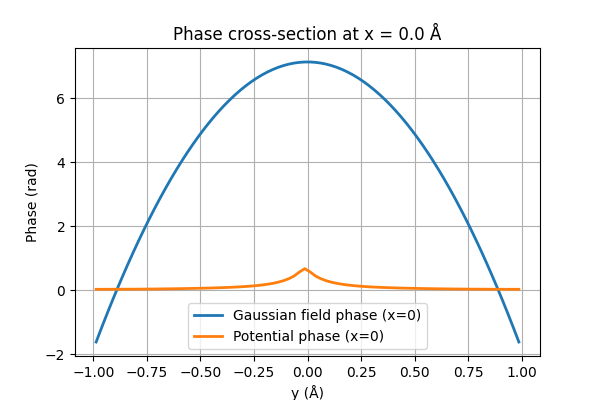

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

im0 = axes[0].imshow(np.angle(np.asarray(gaussian_field)), extent=extent, origin='lower', cmap='viridis')
axes[0].set_title('Probe * Atom Phase')
# axes[0].plot(rx, ry, 'r.', markersize=1, alpha=0.1)
axes[0].set_xlabel('x (Å)')
axes[0].set_ylabel('y (Å)')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

potential_phase = np.exp(1j * sigma * potential.V)
im1 = axes[1].imshow(np.angle(potential_phase), extent=extent, origin='lower', cmap='magma')
axes[1].set_title('Projected potential V')
axes[1].set_xlabel('x (Å)')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)


plt.tight_layout()
plt.show()

x1d, y1d = grid.coords_1d
# Cross-section at x = 0.0
ix = int(np.argmin(np.abs(x1d - 0.0)))  # column index closest to x=0.0

gf_phase = np.angle(np.asarray(gaussian_field))[:, ix]
pot_phase = np.angle(potential_phase)[:, ix]

# Optional unwrap for smoother curves
gf_phase_u = unwrap_phase(gf_phase)
pot_phase_u = unwrap_phase(pot_phase)

plt.figure(figsize=(6,4))
plt.plot(y1d, gf_phase_u, label='Gaussian field phase (x=0)', lw=2)
plt.plot(y1d, pot_phase_u, label='Potential phase (x=0)', lw=2)
plt.xlabel('y (Å)')
plt.ylabel('Phase (rad)')
plt.title('Phase cross-section at x = 0.0 Å')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
# 1D coords from grid
x1d, y1d = grid.coords_1d
xy_coords = grid.coords


analytic_phase = np.real(ray_in.sigma * potential.V_interp(xy_coords)).reshape(grid.shape)
analytic_opl = analytic_phase / k
analytic_opl = np.asarray(analytic_opl) - float(analytic_opl[iy, ix])

functional_phase = np.angle(functional_field)
functional_opl = unwrap_phase(functional_phase) / ray_in.k
functional_opl = np.asarray(functional_opl) - float(functional_opl[iy, ix])

NameError: name 'iy' is not defined

In [ ]:
plt.figure()
plt.plot(x1d, hand_coded_opl[np.argmin(np.abs(y1d - 0.0)), :], label='Hand-coded')
plt.plot(x1d, analytic_opl[np.argmin(np.abs(y1d - 0.0)), :], label='Analytic')
plt.plot(x1d, functional_opl[np.argmin(np.abs(y1d - 0.0)), :], label='Functional')
plt.xlabel('x (Å)')
plt.ylabel('opl (Å)')
plt.title('Phase cross-section at y=0')
plt.grid(True)
plt.legend()
plt.show()